<a href="https://colab.research.google.com/github/jinxtupid/ECE421/blob/main/ECE421_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# Load the data
def load_data():
    with np.load("/content/gdrive/My Drive/4-2/ECE421/notMNIST.npz") as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target


def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test

    
def shuffle(data, target):
    np.random.seed(421)
    rand_idx = np.random.permutation(len(data))
    return data[rand_idx], target[rand_idx]


Mounted at /content/gdrive


In [ ]:
def relu(x):
    return np.maximum(x,0)

def softmax(x):
    x = x - (np.max(x, axis=1)).reshape(x.shape[0],1)

    return np.exp(x) / (np.sum(np.exp(x), axis=1)).reshape(x.shape[0],1)

def compute_layer(x, w, b):
    return np.matmul(x,w) + b

def average_ce(target, prediction):
    N = target.shape[0]
    return -np.sum(target*np.log(prediction)) / N

def grad_ce(target, prediction):
    return prediction - target

In [ ]:
def output_weight(target, prediction, hidden_out):
    softmax_ce = grad_ce(target, prediction)
    hidden_out_transpose = np.transpose(hidden_out)
    return  np.matmul(hidden_out_transpose, softmax_ce)

def output_bias(target, prediction):
    softmax_ce = grad_ce(target, prediction)
    ones = np.ones((1, target.shape[0]))
    return np.matmul(ones, softmax_ce)

def hidden_weight(target, prediction, input, input_out, out_weight):
    input_out[input_out > 0] = 1
    input_out[input_out < 0] = 0

    softmax_ce = grad_ce(target, prediction)
    return  np.matmul(np.transpose(input), (input_out * np.matmul(softmax_ce, np.transpose(out_weight))))

def hidden_bias(target, prediction, input_out, out_weight):
    input_out[input_out > 0] = 1
    input_out[input_out < 0] = 0

    ones = np.ones((1, input_out.shape[0]))
    softmax_ce = grad_ce(target, prediction)
    return  np.matmul(ones, (input_out * np.matmul(softmax_ce, np.transpose(out_weight))))

def forward(data,wh,wo,bh,bo):
    h = compute_layer(data,wh,bh)
    g = relu(h)
    o = compute_layer(g,wo,bo)
    return softmax(o)

def learning(trainData, trainTarget, validData, validTarget, testData, testTarget, w_o, v_o, w_h, v_h, b_o, b_h, epochs, gamma, learning_rate):
    w_v_o = v_o
    b_v_o = b_o
    w_v_h = v_h
    b_v_h = b_h

    train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc  = [], [], [], [], [], []
    for i in range(epochs):

        # print("Iteration:", i)      
        hidden_input_train = compute_layer(trainData, w_h, b_h)
        hidden_output_train = relu(hidden_input_train)
        prediction = softmax(compute_layer(hidden_output_train, w_o , b_o))
        train_loss.append(average_ce(trainTarget,prediction))
        train_acc.append(np.sum(prediction.argmax(axis = 1) == trainTarget.argmax(axis = 1))/trainData.shape[0])


        hidden_input_valid = compute_layer(validData, w_h, b_h)
        hidden_output_valid = relu(hidden_input_valid)
        prediction_valid = softmax(compute_layer(hidden_output_valid, w_o, b_o))
        valid_loss.append(average_ce(validTarget, prediction_valid))
        valid_acc.append(np.sum(prediction_valid.argmax(axis = 1) == validTarget.argmax(axis = 1))/validData.shape[0])

        
        hidden_input_test = compute_layer(testData, w_h, b_h)
        hidden_output_test = relu(hidden_input_test)
        prediction_test = softmax(compute_layer(hidden_output_test, w_o, b_o))
        test_loss.append(average_ce(testTarget, prediction_test))
        test_acc.append((np.sum(prediction_test.argmax(axis = 1) == testTarget.argmax(axis = 1)))/(testData.shape[0]))

        # updating parameters
        w_v_o = gamma * w_v_o + learning_rate * output_weight(trainTarget, prediction, hidden_output_train)
        b_v_o = gamma * b_v_o + learning_rate * output_bias(trainTarget, prediction)
        w_v_h = gamma * w_v_h + learning_rate * hidden_weight(trainTarget, prediction, trainData, hidden_input_train, w_o)       
        b_v_h = gamma * b_v_h + learning_rate * hidden_bias(trainTarget, prediction, hidden_input_train, w_o)

        w_o = w_o - w_v_o
        b_o = b_o - b_v_o
        w_h = w_h - w_v_h
        b_h = b_h - b_v_h

    return w_o, b_o, w_h, b_h, train_acc, valid_acc, test_acc, train_loss, valid_loss, test_loss

def Xavier(unitsin, unitsout):
  return np.random.normal(0, np.sqrt(2/(unitsin + unitsout)), (unitsin,unitsout))

0.9093245227606461
0.9121666666666667
0.9985
0.7718570778316731
0.724208224482581
0.006936827205918513
399.71449398994446


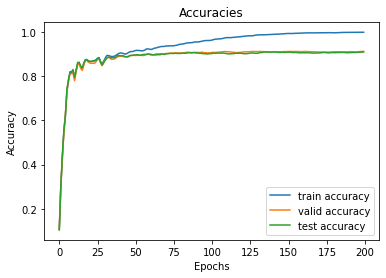

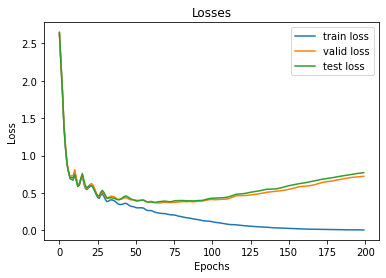

In [ ]:
import time
trainData, validData, testData, trainTarget, validTarget, testTarget = load_data()
trainData = trainData.reshape((trainData.shape[0], -1))
validData = validData.reshape((validData.shape[0], -1))
testData = testData.reshape((testData.shape[0], -1))

train_target, valid_target, test_target = convert_onehot(trainTarget, validTarget, testTarget)

H = 1000
epochs = 200
gamma = 0.99
learning_rate = 0.00001

w_o = Xavier(H,10)
w_h = Xavier(784,H)
v_o = np.full((H, 10), 1e-5)
v_h = np.full((trainData.shape[1],H), 1e-5)
b_o = np.zeros((1, 10))
b_h = np.zeros((1, H))

start = time.time()

weight_o, bias_o, weight_h, bias_h, train_acc, valid_acc, test_acc, \
train_loss, valid_loss, test_loss = learning(trainData, train_target, \
validData, valid_target, testData, test_target, w_o, v_o, w_h, v_h, b_o, \
b_h, epochs, gamma, learning_rate)

end = time.time()


# plotting
iterations = range(len(train_acc))
plt.figure()
plt.plot(iterations, train_acc)
plt.plot(iterations, valid_acc)
plt.plot(iterations, test_acc)
plt.legend(['train accuracy', 'valid accuracy', 'test accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracies")


plt.figure()
plt.plot(iterations, train_loss)
plt.plot(iterations, valid_loss)
plt.plot(iterations, test_loss)
plt.legend(['train loss', 'valid loss', 'test loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Losses")      

# print(test_acc[-1])
# print(valid_acc[-1])
# print(train_acc[-1])

# print(test_loss[-1])
# print(valid_loss[-1])
# print(train_loss[-1])

# print(end-start)